In [0]:
import numpy as np
import pandas as pd
import scipy  #########   scipy旗下有matplotlib等绘图软件
import io
import matplotlib.pyplot as plt
import sklearn as skl #绘图常用
import seaborn as sns #绘图常用
import lightgbm as lgb
import gc
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score  ########## 关键就是比较auc的面积
from sklearn.ensemble import RandomForestClassifier
import os
import xgboost as xgb

In [0]:
# 读取 google drive里面的csv数据
# To read csv file which is stored in Googledrive:

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file, by right clicking on the file and copying the shared link for the ID.
downloaded_train = drive.CreateFile({'id':'1Yur_9PS2q1LVVuzGvXSXYsue6thlLitJ'}) # replace the id with id of file you want to access
downloaded_train.GetContentFile('Python_project_eda.csv')
downloaded_test = drive.CreateFile({'id':'1yXQokLhHJ3ZUfdV9Ut5lBlVkPsXoakDS'}) # replace the id with id of file you want to access
downloaded_test.GetContentFile('Python_project_experiment.csv')

#3. Read file as panda dataframe
Python_project_eda = pd.read_csv("Python_project_eda.csv")
Python_project_experiment = pd.read_csv("Python_project_experiment.csv")

In [0]:
######################## 第一部分 做原始老数据的exploratory data analysis  ##################################
Python_project_eda.head(5)

,buyer_week_before,clicked_buy_before,country,existing_buyer,initial_fop_set,made_purchase_before,saw_cart_before,spend_usd_next_14_days,user_added_credit_card,user_added_dcb,user_added_fop,user_added_gift_card,user_added_paypal,user_id,visit_before
0,0,0.0,IN,0,False,0.0,1.0,NaN,NaN,NaN,0,NaN,NaN,18321316048201303366,1
1,0,0.0,IN,0,False,0.0,1.0,NaN,NaN,NaN,0,NaN,NaN,13705367724816913241,1
2,0,NaN,IN,0,False,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,6605724765451655114,0
3,0,1.0,CA,1,True,1.0,1.0,7.398815,1.0,0.0,1,0.0,0.0,2340067911948261502,1
4,7,1.0,PL,1,True,1.0,1.0,NaN,0.0,1.0,1,0.0,0.0,11891045596810635427,1


In [0]:
Python_project_eda[Python_project_eda.country=="US"].head(5)  #######  显示特定的行   ###########

,buyer_week_before,clicked_buy_before,country,existing_buyer,initial_fop_set,made_purchase_before,saw_cart_before,spend_usd_next_14_days,user_added_credit_card,user_added_dcb,user_added_fop,user_added_gift_card,user_added_paypal,user_id,visit_before
14,0,1.0,US,1,True,1.0,1.0,33.82,1.0,1.0,1,0.0,1.0,10301202680834406137,1
17,1,1.0,US,1,True,1.0,1.0,1.98,1.0,0.0,1,1.0,0.0,16569805868309262813,1
25,0,1.0,US,1,True,1.0,1.0,NaN,NaN,NaN,0,NaN,NaN,597021183915827167,1
43,0,0.0,US,1,True,0.0,1.0,NaN,0.0,1.0,1,0.0,0.0,11676406094140140796,1
51,8,1.0,US,1,True,1.0,1.0,71.82,1.0,0.0,1,0.0,0.0,4756932245224773331,1


In [0]:
Python_project_eda.shape

(566699, 15)

In [0]:
Python_project_eda=Python_project_eda.drop_duplicates() ######## 去除重复的行  ###########
Python_project_eda.shape

(566699, 15)

In [0]:
user_added_credit_card_group = Python_project_eda.groupby("user_added_credit_card")["buyer_week_before", "clicked_buy_before", "made_purchase_before", "saw_cart_before", "spend_usd_next_14_days", "visit_before"].sum()

In [0]:
user_added_credit_card_group # 看添加信用卡对销售额的影响

,buyer_week_before,clicked_buy_before,made_purchase_before,saw_cart_before,spend_usd_next_14_days,visit_before
user_added_credit_card,,,,,,
0.0,126290,53451.0,42125.0,70516.0,1.811866e+06,72406
1.0,225037,71447.0,61513.0,86445.0,4.155724e+06,88231


In [0]:
user_added_dcb_group = Python_project_eda.groupby("user_added_dcb")["buyer_week_before", "clicked_buy_before", "made_purchase_before", "saw_cart_before", "spend_usd_next_14_days", "visit_before"].sum()

In [0]:
user_added_dcb_group # 看添加借记卡对销售额的影响

,buyer_week_before,clicked_buy_before,made_purchase_before,saw_cart_before,spend_usd_next_14_days,visit_before
user_added_dcb,,,,,,
0.0,174711,63329.0,53512.0,80835.0,2.604951e+06,82776
1.0,176616,61569.0,50126.0,76126.0,3.362639e+06,77861


In [0]:
user_added_gift_card_group = Python_project_eda.groupby("user_added_gift_card")["buyer_week_before", "clicked_buy_before", "made_purchase_before", "saw_cart_before", "spend_usd_next_14_days", "visit_before"].sum()

In [0]:
user_added_gift_card_group # 看添加礼品卡对销售额的影响

,buyer_week_before,clicked_buy_before,made_purchase_before,saw_cart_before,spend_usd_next_14_days,visit_before
user_added_gift_card,,,,,,
0.0,261798,98514.0,78345.0,126674.0,3.875877e+06,130053
1.0,89529,26384.0,25293.0,30287.0,2.091714e+06,30584


In [0]:
user_added_paypal_group = Python_project_eda.groupby("user_added_paypal")["buyer_week_before", "clicked_buy_before", "made_purchase_before", "saw_cart_before", "spend_usd_next_14_days", "visit_before"].sum()

In [0]:
user_added_paypal_group # 看添加paypal对销售额的影响

,buyer_week_before,clicked_buy_before,made_purchase_before,saw_cart_before,spend_usd_next_14_days,visit_before
user_added_paypal,,,,,,
0.0,306639,111528.0,91878.0,141310.0,5.284654e+06,144684
1.0,44688,13370.0,11760.0,15651.0,6.829366e+05,15953


In [0]:
######################## 第二部分 做新老数据的A/B test  ##################################

Python_project_experiment.shape

(49166, 8)

In [0]:
Python_project_experiment=Python_project_experiment.dropna(subset=['country', 'date'])

In [0]:
Python_project_experiment.shape

(12339, 8)

In [0]:
experiment_data = Python_project_experiment.sort_values(['country','date'],ascending=[True, True]).reset_index()  #######  按国家和日期梳理排序  #####
experiment_data.head(5)

,index,country,date,experiment_id,order_id,spend_usd,user_bucket,user_id,vertical
0,44272,AE,2017-04-03,12624548,8078410735682954089,1.984784,5,15342218896746506117,GAMES
1,28416,AE,2017-04-05,12624548,18081415353723908788,0.952926,6,921275339006250633,GAMES
2,165,AT,2017-04-01,12624549,13815999582826879773,10.661877,1,10712080054886617313,GAMES
3,327,AT,2017-04-01,12624549,6849040377355354671,9.594622,9,14625640117659796845,GAMES
4,328,AT,2017-04-01,12624549,7427092356856955286,9.594622,9,14625640117659796845,GAMES


In [0]:
#goal:compare revernue performance between red(id为12624548) and blue(id为12624549)， 红色数据是实验组， 蓝色数据是对照组
ids = np.unique(Python_project_experiment["experiment_id"])
red_button = ids[0]
blue_button = ids[1]

In [0]:
red_button, blue_button # 定义实验组和对照组id

(12624548, 12624549)

In [0]:
# 拆分原数据集为实验组数据集和对照组数据集
red_button_data = Python_project_experiment[["date", "spend_usd"]][Python_project_experiment.experiment_id==red_button]
blue_button_data = Python_project_experiment[['date','spend_usd']][Python_project_experiment.experiment_id == blue_button]

In [0]:
red_button_data.shape

(6386, 2)

In [0]:
blue_button_data.shape

(5953, 2)

In [0]:
# 红色数据是实验组， 蓝色数据是对照组
experimentgroup=red_button_data.groupby("date")["spend_usd"].sum()
controlgroup = blue_button_data.groupby('date')['spend_usd'].sum()

In [0]:
experimentgroup # 实验组在7天内消费的结果

date
2017-04-01    17963.103570
2017-04-02     8893.580387
2017-04-03    12106.731493
2017-04-04     8891.168345
2017-04-05     9677.074447
2017-04-06     8218.982812
2017-04-07    10732.362252
Name: spend_usd, dtype: float64

In [0]:
experimentgroup.sum() # 实验组在7天内消费的结果

76483.00330599972

In [0]:
controlgroup # 对照组在7天内消费的结果

date
2017-04-01    15083.331851
2017-04-02     9767.245650
2017-04-03     8678.279044
2017-04-04     7460.887996
2017-04-05     8103.942467
2017-04-06     9589.755734
2017-04-07    10012.156748
Name: spend_usd, dtype: float64

In [0]:
controlgroup.sum() # 对照组在7天内消费的结果

68695.59948999969

In [0]:
(76483.00330599972-68695.59948999969)/68695.59948999969

0.11336102856389921

In [0]:
########## 结论    the test version help increase CTR and total revenue with 11.3% revenue uplift. We can now help the team make the right decisions.  ################
# 实验表明实验组在7天内消费总额多于对照组11%，是明显有促销作用的。

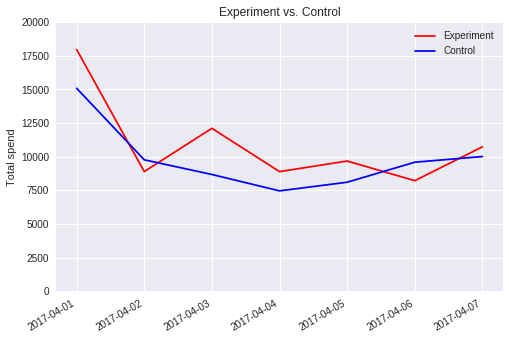

In [0]:
########  Plot 表示描线图，  hist表示直方图   ############

fig, ax = plt.subplots()
ax.plot(experimentgroup, color="red", label="Experiment")
ax.plot(controlgroup, color="blue", label = "Control")


ax.set_ylim(0,20000)
ax.set_title("Experiment vs. Control")
ax.set_ylabel("Total spend")

#make legend
ax.legend()

#format date
plt.gcf().autofmt_xdate()

In [0]:
###### There might be learning effect for users to get used to the change. Help the team understand this. ############
# 注意到日期02到03，红色实验组数据相比于蓝色组有明显上提但也具有延迟性，说明新的消费者对于促销手段具有学习适应期，适应期过后消费大增。

In [0]:
red_mean = red_button_data["spend_usd"].mean()
red_sd = red_button_data["spend_usd"].std()
blue_mean = blue_button_data["spend_usd"].mean()
blue_sd = blue_button_data["spend_usd"].std()

In [0]:
red_mean, red_sd, blue_mean, blue_sd

(11.97666822831199, 20.450579675089507, 11.539660589618586, 19.858210078491297)